# Notebook description

This notebook demonstrates the exponential behaviour of the synapse and its noisiness when receiving spiking input. Demoed is the state of a synapse with fixed time constant as it receives Poisson and periodic spikes at varying rates.

The synapse is a first order lowpass filter described by

$$\tau\dot{x}=-x+\sum_i\delta(t-t_i)$$

where $\tau$ is the synaptic time constant and $t_i$ describes the arrival time of the $i$th spike.

The input spike rate is $\lambda$, and the spike times are drawn from either a Poisson process or are periodic.

# Demo

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from IPython.html.widgets import interactive
from IPython.display import display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def th_unif_xmax(lam, tau):
    """theoretical steady-state maximum value of synapse receiving periodic input"""
    return 1./(tau*(1-np.exp(-1/(lam*tau))))

def th_unif_xmin(lam, tau):
    """theoretical steady-state minimum value of synapse receiving periodic input"""
    return (np.exp(-1/(lam*tau)))/(tau*(1-np.exp(-1/(lam*tau))))

def run_synapse(dt, T, f, pstc, mode):
    assert (mode == 'periodic') or (mode == 'poisson')
    if mode == 'periodic':
        Tf = 1./f 
    elif mode == 'poisson':
        Tf = np.random.exponential(1./f)
    elapsed = Tf

    steps = int(np.ceil(T/dt))
    decay = np.expm1(-dt/pstc)+1
    increment = -np.expm1(-dt/pstc)

    time = np.arange(steps)*dt
    state = np.zeros(steps)

    for i in range(steps-1):
        state[i+1] = state[i]*decay
        if elapsed >= Tf:
            state[i+1] += increment/dt
            elapsed = elapsed - Tf + dt
            if mode == 'poisson':
                Tf = np.random.exponential(1./f)
        else:
            elapsed += dt

    return time, state

pstc = .05   # post synaptic time constant
T = 10*pstc      # total simulation time

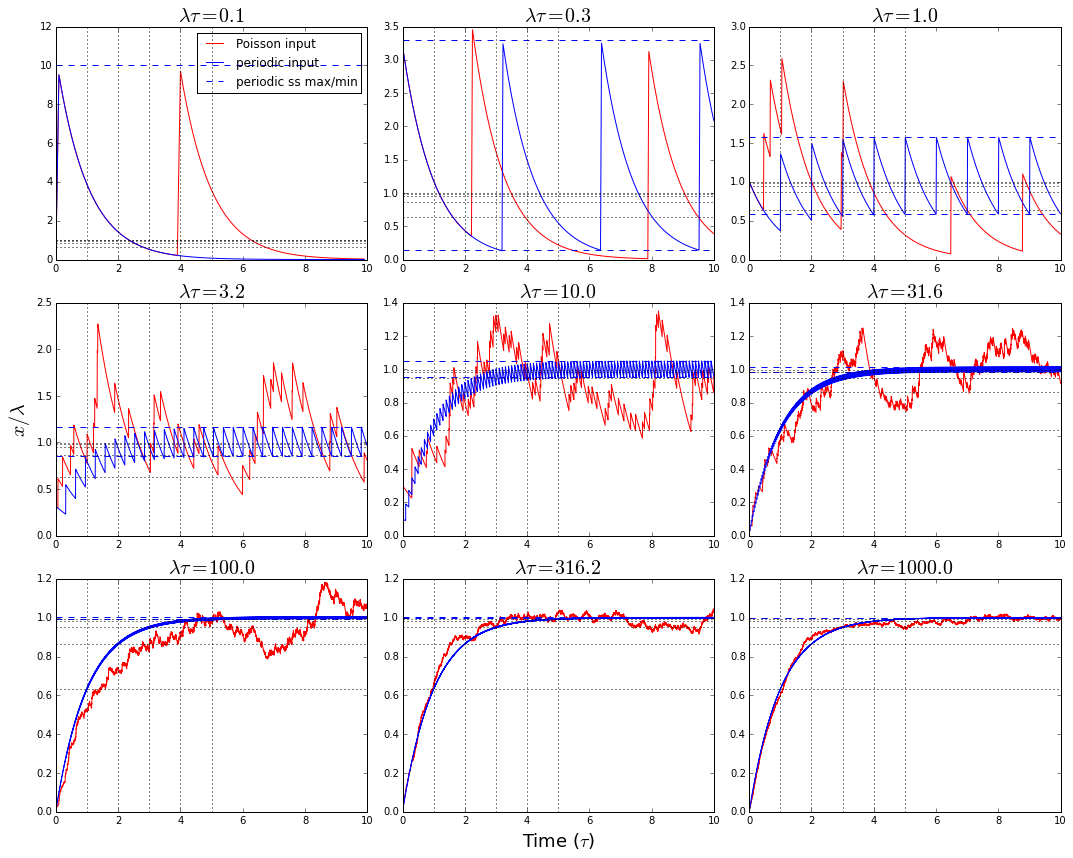

In [3]:
# demo synapse
fig = plt.figure(figsize=(15,12))

rates = np.logspace(-1,3,9)/pstc
for idx, f in enumerate(rates):
    dt = 1./(f*100.)
    time, state_uniform = run_synapse(dt, T, f, pstc, 'periodic')
    _, state_poisson = run_synapse(dt, T, f, pstc, 'poisson')
    
    x_u = th_unif_xmax(f, pstc)
    x_l = th_unif_xmin(f, pstc)
    
    # plot timeseries
    ax = fig.add_subplot(3,3,idx+1)
    ax.plot(time/pstc, state_poisson/f, 'r', label='Poisson input')
    ax.plot(time/pstc, state_uniform/f, 'b', label='periodic input')
    ax.axhline(x_u/f, c='b', ls='--', label='periodic ss max/min')
    ax.axhline(x_l/f, c='b', ls='--')
    for i in xrange(6):
        ax.axvline(i, c='k', ls=':')
        ax.axhline((1-np.exp(-i)), c='k', ls=':')
    ax.set_title(r'$\lambda\tau=%3.1f$' % (f*pstc), fontsize=20)

plt.subplot(331)
plt.legend(loc='upper right')
plt.subplot(338)
plt.xlabel(r'Time ($\tau$)', fontsize=18)
plt.subplot(334)
plt.ylabel('$x/\lambda$', fontsize=20)
plt.tight_layout()

The plots are normalized in time to units of $\tau$ and are normalized in synaptic value by $\lambda$. The input spike rates are expressed as $\lambda\tau$, the expected number of spikes that are input to the synapse in a single time constant.

Here are a few points to observe from the plots:
 - The synapse reaches a steady state value equal to the input firing rate in expectation
 - The speed at which the synapse value approaches the input firing rate value is determined by the synaptic time constant
 - The synapse with periodic spiking input is much less noisy than the synapse with Poisson spiking input. The synapse with periodic input is, in fact, bounded in steady state. These points made more precisely when comparing
 [this notebook](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/synapse/synapse_SNR_poisson.ipynb) 
 on Poisson input spiking and 
 [this notebook](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/synapse/synapse_SNR_periodic.ipynb)
 on periodic input spiking

Below is an interactive plot. Run it locally to be able to see the effect of varying simulation parameters.

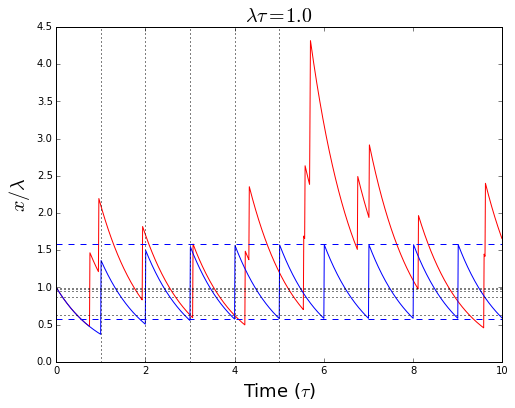

In [4]:
def interactive_synapse(log10lamtau=0):
    f = 10**log10lamtau/pstc
    dt = 1./(f*100.)
    time, state_periodic = run_synapse(dt, T, f, pstc, 'periodic')
    _, state_poisson = run_synapse(dt, T, f, pstc, 'poisson')
    
    x_u = th_unif_xmax(f, pstc)
    x_l = th_unif_xmin(f, pstc)
    
    fig, ax = plt.subplots(figsize=(8,6))

    ax.plot(time/pstc, state_poisson/f, 'r', label='Poisson input')
    ax.plot(time/pstc, state_periodic/f, 'b', label='periodic input')
    ax.axhline(x_u/f, c='b', ls='--', label='periodic ss max/min')
    ax.axhline(x_l/f, c='b', ls='--')
    for i in xrange(6):
        ax.axvline(i, c='k', ls=':')
        ax.axhline((1-np.exp(-i)), c='k', ls=':')   
    ax.set_xlabel(r'Time ($\tau$)', fontsize=18)
    ax.set_ylabel('$x/\lambda$', fontsize=20)
    ax.set_title(r'$\lambda\tau=%.1f$' % (f*pstc), fontsize=20)

display(interactive(interactive_synapse, log10lamtau=(-1, 3, 1)))